Resources: https://www.mdpi.com/2077-0472/8/5/70

In [88]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
# Function to display a single band
def display_band(band, title, cmap='gray', colour_bar=False):
    plt.figure(figsize=(6, 6))
    plt.imshow(band, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    if colour_bar:
        plt.colorbar()
    plt.show()


In [90]:
# Path to the image file
image_path = '8928dec4ddbffff/DJI_0876.JPG'

# Open the image file using rasterio
with rasterio.open(image_path) as src:
    blue = src.read(1)
    green = src.read(2)
    red = src.read(3)


/Users/kevinlacaille/miniconda/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


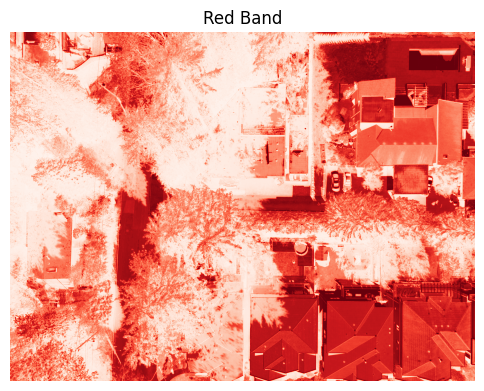

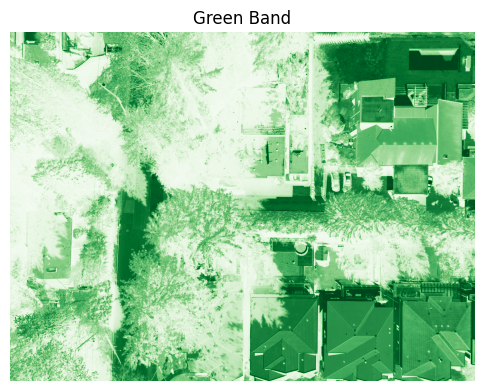

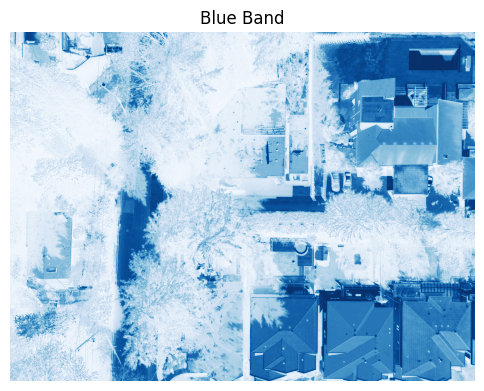

In [98]:
# Display the R, G, B bands
display_band(red_band, 'Red Band', cmap='Reds')
display_band(green_band, 'Green Band', cmap='Greens')
display_band(blue_band, 'Blue Band', cmap='Blues')


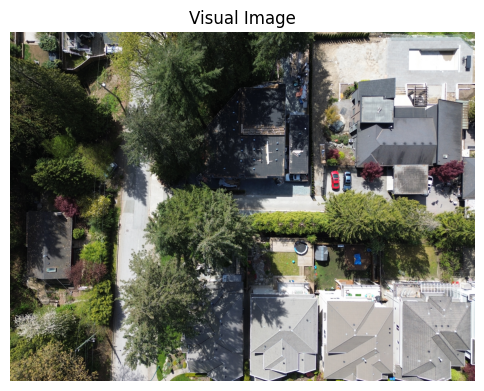

In [92]:
# To construct a visual image, we will need the red, green, and blue bands
visual_image = np.dstack((blue, green, red))
display_band(visual_image, 'Visual Image')

In [93]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

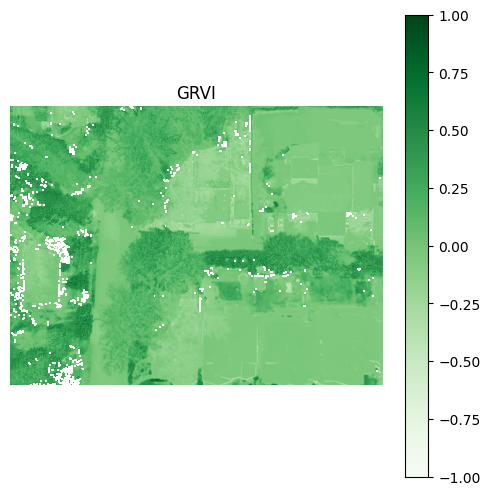

In [94]:
# Calculate Green Red Vegetation Index (GRVI)
grvi = (green.astype(float) - 1.1 * red.astype(float)) / (
    green.astype(float) + 1.1 * red.astype(float))
display_band(grvi, 'GRVI', cmap='Greens', colour_bar=True)

In [95]:
green_mask = np.full(grvi.shape, np.nan)
land_mask = np.full(grvi.shape, np.nan)

green_mask[grvi >= 0] = 1
land_mask[grvi < 0] = 1

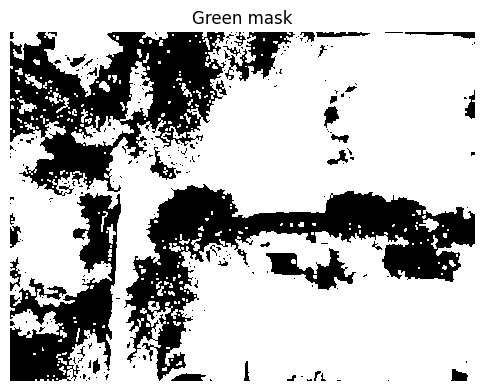

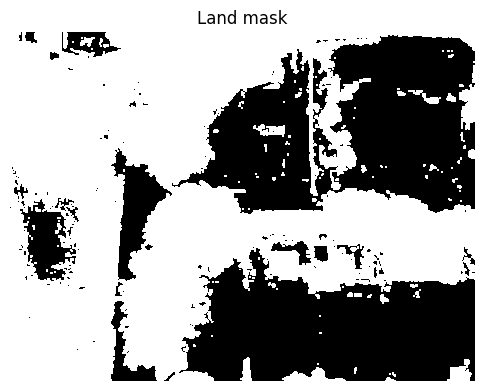

In [96]:
display_band(green_mask, 'Green mask')
display_band(land_mask, 'Land mask')

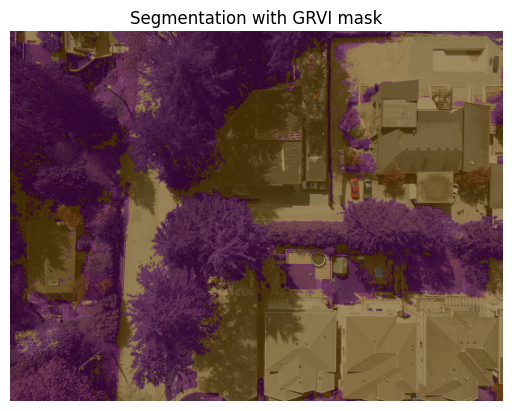

In [97]:
# Create a mask overlay with grey color
green_mask_overlay = np.zeros_like(visual_image)
green_mask_overlay[:, :, 0] = 128  # Red channel for grey
green_mask_overlay[:, :, 1] = 0  # Green channel for grey
green_mask_overlay[:, :, 2] = 128  # Blue channel for grey

# Apply the green mask to the mask overlay
g_mask = np.isnan(green_mask)
green_mask_overlay[g_mask] = [0, 0, 0]  # Transparent where mask is not applied

land_mask_overlay = np.zeros_like(visual_image)
land_mask_overlay[:, :, 0] = 255  # Red channel for grey
land_mask_overlay[:, :, 1] = 165  # Green channel for grey
land_mask_overlay[:, :, 2] = 0  # Blue channel for grey

# Apply the green mask to the mask overlay
l_mask = np.isnan(land_mask)
land_mask_overlay[l_mask] = [0, 0, 0]  # Transparent where mask is not applied

# Display the visual image
plt.imshow(visual_image)
plt.title("Segmentation with GRVI mask")

# Overlay the mask with 50% transparency
plt.imshow(green_mask_overlay, alpha=0.5)
plt.imshow(land_mask_overlay, alpha=0.25)
plt.axis('off')
plt.show()


In [109]:
# count number of pixels in green_mask
green_pixels = np.nansum(green_mask)

# count total pixels
total_pixels = red_band.size

N_PIXELS_PER_TREE = 500000
n_trees = green_pixels / N_PIXELS_PER_TREE
print(f'Number of trees: {n_trees:.0f}')


Number of trees: 11


In [110]:
def count_trees(image_path, n_pixels_per_tree=200000):
    with rasterio.open(image_path) as src:
        red_band = src.read(1)
        green_band = src.read(2)
        grvi = (green_band.astype(float) - 1.1 * red_band.astype(float)) / (
            green_band.astype(float) + 1.1 * red_band.astype(float))

        green_mask = np.full(grvi.shape, np.nan)
        land_mask = np.full(grvi.shape, np.nan)

        green_mask[grvi >= 0] = 1
        land_mask[grvi < 0] = 1

        green_pixels = np.nansum(green_mask)
        total_pixels = red_band.size
        n_trees = green_pixels / n_pixels_per_tree

        return n_trees

In [111]:
# CO2 absorbed per tree in kg (https://ecotree.green/en/how-much-co2-does-a-tree-absorb#:~:text=A%20tree%20absorbs%20approximately%2025kg%20of%20CO2%20per%20year&text=But%20really%20a%20tree%20absorbs,a%20tree%20absorbs%20so%20interesting.)
carbon_absorbed_per_tree = 25

In [113]:
# Calculate the amount of carbon absorbed by the trees
carbon_absorbed = n_trees * carbon_absorbed_per_tree
print(f'Amount of carbon absorbed: {carbon_absorbed:.0f} kg')

Amount of carbon absorbed: 284 kg


In [ ]:
# given certain limitations of system (80m altitude, size of a tree IRL, etc.), we can give min/max size of tree
# do morphological operations to get rid of small objects and close gaps in the mask
# this way we dont falsely count small objects as trees (ie bushes, etc.) and flasely count large objects as multiple trees (ie a forest as multiple trees or a field as a single tree)